In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import seaborn as sns, pandas as pd, numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures, PowerTransformer
from sklearn.metrics import make_scorer,f1_score,accuracy_score,confusion_matrix,roc_auc_score,roc_curve
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, NuSVC
import matplotlib.pyplot as plt

def minha_metrica(y_true, y_pred):
    threshold = 0.5  # Defina o threshold desejado
    

    # Calcule o true positive rate para o threshold dado
    tp = np.sum((y_true == 1) & (y_pred >= threshold))
    fn = np.sum((y_true == 1) & (y_pred < threshold))
    tpr = tp / (tp + fn)

    # Calcule o true negative rate para o threshold dado
    tn = np.sum((y_true == 0) & (y_pred < threshold))
    fp = np.sum((y_true == 0) & (y_pred >= threshold))
    tnr = tn / (tn + fp)

    # Calcule o produto dos passos 1 e 2
    product = tpr * tnr

    # Retorne a raiz quadrada do passo 3
    return np.sqrt(product)

In [11]:
data = pd.read_csv("dados_classificacao/dados_hospital.csv", sep=',')
data.drop(['cancer'], axis=1,inplace=True)
data = pd.get_dummies(data)

target = 'no_show_SIM'

X, y = data.drop([target, 'no_show_NÃO'], axis=1), data[target]

X_traina, X_testa, y_traina, y_testa = train_test_split(X,y,test_size=0.2, stratify=y, random_state=42)


# Q1 = data.quantile(0.25)
# Q3 = data.quantile(0.75)
# IQR = Q3 - Q1
# limite_inferior = Q1 - 2.5 * IQR
# limite_superior = Q3 + 2.5 * IQR
# data_sem_outliers = data[(data >= limite_inferior) & (data <= limite_superior)]

# data_sem_outliers.dropna(inplace=True)

# X_so = data_sem_outliers.drop([target, 'no_show_NÃO'], axis=1)
# y_so = data_sem_outliers[target]
# X_trainb, X_testb, y_trainb, y_testb = train_test_split(X_so,y_so,test_size=0.2, stratify=y_so, random_state=0)

dt = [[X_traina,y_traina,X_testa,y_testa],[X_traina,y_traina,X_testa,y_testa]]

[0.61188717 0.62986701 0.62755651] [0.39595134438753293, 0.4728682170542636]
[[ 36  75]
 [809 757]]


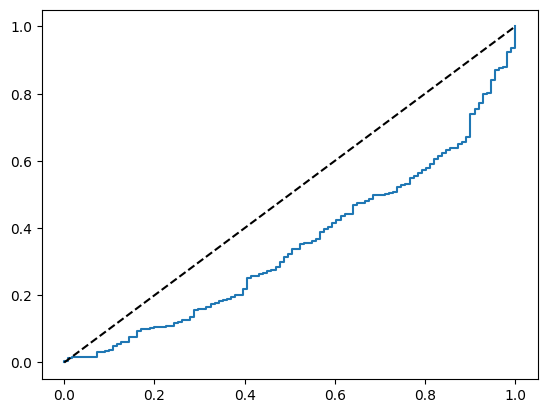

In [13]:
X_train,y_train,X_test,y_test = dt[0]

my_scorer = make_scorer(minha_metrica,greater_is_better=True)

pipe = Pipeline([('escala',StandardScaler()),('modelo', LogisticRegression(penalty='l2',class_weight='balanced',C = 1e-12,max_iter=1000000))]) 

cvr = cross_validate(pipe, X_train, y_train, cv = 3, scoring=my_scorer, return_estimator=True)
scores = cvr['test_score']
estimators = cvr['estimator']
best_model = estimators[np.argmax(cvr['test_score'])]
y_pred = best_model.predict_proba(X_test)[:,0]
print(scores,[minha_metrica(y_test,y_pred),accuracy_score(y_test,y_pred>=0.5)])
print(confusion_matrix(y_pred=y_pred>=0.5,y_true=y_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='Curva ROC')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')

0.9536384788626101 [0.12154585177511781, 0.07811568276684555]
{'modelo__C': 10.0}
[[ 107    4]
 [1542   24]]


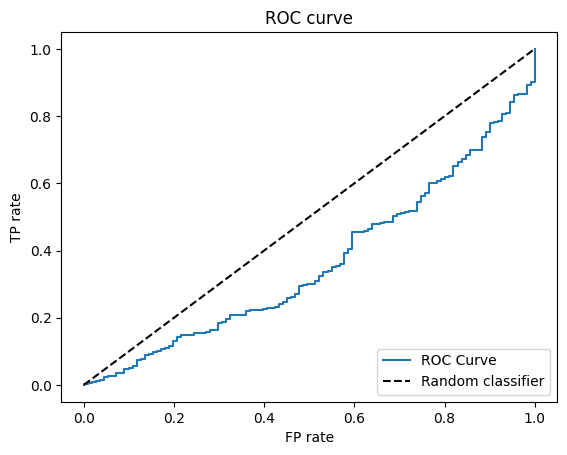

In [38]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE 
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours, NeighbourhoodCleaningRule, OneSidedSelection

balancear = BorderlineSMOTE()

X_train,y_train,X_test,y_test = dt[0]
X_resampled, y_resampled = balancear.fit_resample(X_train, y_train)

my_scorer = make_scorer(minha_metrica,greater_is_better=True)


 
param_grid = {
    "modelo__C":np.linspace(1.0e+1,1.0e+2,10),
}

pipe = Pipeline([('poli',PolynomialFeatures(2)),('escala',StandardScaler()),('modelo', LogisticRegression(penalty='l2',max_iter=1000000))])
# pipe = Pipeline([('poli',PolynomialFeatures()),('escala',StandardScaler()),('modelo', LogisticRegression(penalty='l2',solver='lbfgs',max_iter=1000000))])

search = GridSearchCV(pipe, param_grid, scoring = my_scorer,cv = 3, n_jobs=-1)
search.fit(X_resampled, y_resampled)
bests = search.best_estimator_
y_pred = bests.predict_proba(X_test)[:,0]
print(search.best_score_,[minha_metrica(y_test,y_pred),accuracy_score(y_test,y_pred>=0.5)])
print(search.best_params_)
print(confusion_matrix(y_pred=y_pred>=0.5,y_true=y_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

{'modelo__C': 1.0}
0.9611452715657368 [0.0, 0.9338103756708408]
[[   0  111]
 [   0 1566]]


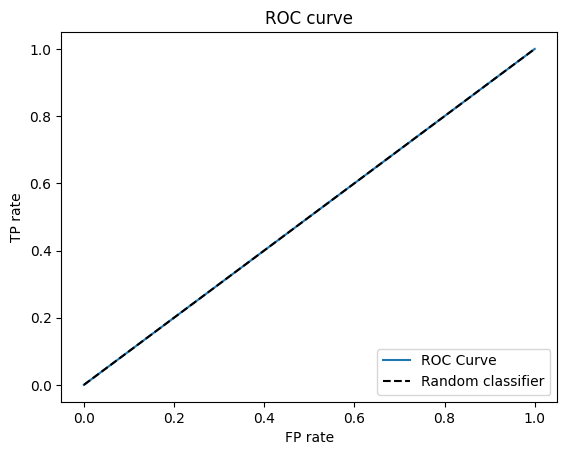

In [40]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE 
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours, NeighbourhoodCleaningRule, OneSidedSelection


balancear = SMOTE()

X_train,y_train,X_test,y_test = dt[0]
X_resampled, y_resampled = balancear.fit_resample(X_train, y_train)

my_scorer = make_scorer(minha_metrica,greater_is_better=True)


 
param_grid = {
    "modelo__C":np.linspace(1,10,5),
    # "modelo_gamma" : ['scale','auto',0.001, 0.1, 1, 2]
}

pipe = Pipeline([('escala',StandardScaler()),('modelo', SVC(kernel='rbf',gamma = 'scale'))])

search = GridSearchCV(pipe, param_grid, scoring = my_scorer, cv = 3, n_jobs=-1)
search.fit(X_resampled, y_resampled)
bests = search.best_estimator_
scores = search.best_score_

# search = cross_validate(pipe, X_resampled, y_resampled, cv = 3, scoring = my_scorer, return_estimator = True)
# scores = search['test_score']
# estimators = search['estimator']
# bests = estimators[np.argmax(cvr['test_score'])]

y_pred = bests.predict(X_test)
print(search.best_params_)

print(scores,[minha_metrica(y_test,y_pred),accuracy_score(y_test,y_pred)])
print(confusion_matrix(y_pred=y_pred,y_true=y_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE 

balancear = SMOTE()

X_train,y_train,X_test,y_test = dt[0]
X_resampled, y_resampled = balancear.fit_resample(X_train, y_train)

my_scorer = make_scorer(minha_metrica,greater_is_better=True)

poly = PolynomialFeatures(degree = 6)
pipe = Pipeline([(('poli',poly)),('escala',StandardScaler()),('modelo', LogisticRegression(penalty='l2',C = 1e-12,max_iter=1000000))]) 
# pipe = Pipeline([(('poli',poly)),('trasforma',PowerTransformer()),('modelo', LogisticRegression(penalty='l2',C = .0000000000010,max_iter=1000000))]) 

cvr = cross_validate(pipe, X_resampled, y_resampled, cv = 3, scoring=my_scorer, return_estimator=True)
scores = cvr['test_score']
estimators = cvr['estimator']
best_model = estimators[np.argmax(cvr['test_score'])]
y_pred = best_model.predict_proba(X_test)[:,0]
print(scores,[minha_metrica(y_test,y_pred),accuracy_score(y_test,y_pred>=0.5)])
print(confusion_matrix(y_pred=y_pred>=0.5,y_true=y_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='Curva ROC')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')

[0.26371832 0.24022599 0.26495988] [0.20699624428065286, 0.1037567084078712]
[[  98   13]
 [1490   76]]


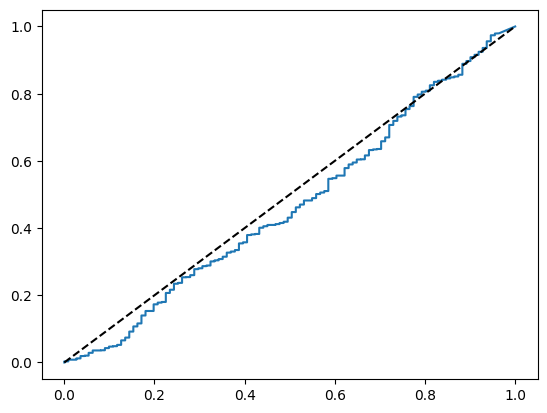

In [196]:
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours, NeighbourhoodCleaningRule, OneSidedSelection

balancear = TomekLinks()

X_train,y_train,X_test,y_test = dt[0]
X_resampled, y_resampled = balancear.fit_resample(X_train, y_train)

my_scorer = make_scorer(minha_metrica,greater_is_better=True)

poly = PolynomialFeatures(degree = 3)

pipe = Pipeline([(('poli',poly)),('escala',StandardScaler()),('modelo', LogisticRegression(penalty='l2',C = 50.050,max_iter=1000000))]) 
# pipe = Pipeline([('trasforma',PowerTransformer()),('modelo', LogisticRegression(penalty='l2',C = .005050,max_iter=1000000))]) 

cvr = cross_validate(pipe, X_resampled, y_resampled, cv = 3, scoring = my_scorer, return_estimator=True)
scores = cvr['test_score']
estimators = cvr['estimator']
best_model = estimators[np.argmax(cvr['test_score'])]
y_pred = best_model.predict_proba(X_test)[:,0]
print(scores,[minha_metrica(y_test,y_pred),accuracy_score(y_test,y_pred>=0.5)])
print(confusion_matrix(y_pred=y_pred>=0.5,y_true=y_test))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='Curva ROC')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')

/Users/moi6/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5389382919766442 [0.44085743139369327, 0.5158020274299344]
{'modelo__C': 3.25e-19, 'poli__degree': 2}
[[ 41  70]
 [742 824]]


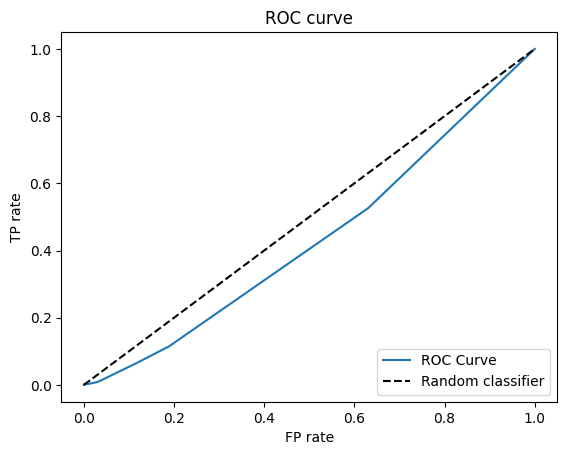

In [122]:
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours, NeighbourhoodCleaningRule, OneSidedSelection

balancear = RandomUnderSampler()

X_train,y_train,X_test,y_test = dt[0]
X_resampled, y_resampled = balancear.fit_resample(X_train, y_train)

my_scorer = make_scorer(minha_metrica,greater_is_better=True)


 
param_grid = {
    "poli__degree": [2,3,4],
    "modelo__C":np.linspace(1.0e-19,1.0e-18,5),
}

pipe = Pipeline([('poli',PolynomialFeatures()),('escala',StandardScaler()),('modelo', LogisticRegression(penalty='l2',max_iter=1000000))])
search = GridSearchCV(pipe, param_grid, scoring = my_scorer,cv = 3, n_jobs=-1)
search.fit(X_resampled, y_resampled)
bests = search.best_estimator_
y_pred = bests.predict_proba(X_test)[:,0]
print(search.best_score_,[minha_metrica(y_test,y_pred),accuracy_score(y_test,y_pred>=0.5)])
print(search.best_params_)
print(confusion_matrix(y_pred=y_pred>=0.5,y_true=y_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()